In [1]:
!wget https://raw.githubusercontent.com/yadneshSalvi/text-gcn/main/rt-polarity.neg

--2020-12-20 14:55:38--  https://raw.githubusercontent.com/yadneshSalvi/text-gcn/main/rt-polarity.neg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.64.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.64.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 612290 (598K) [text/plain]
Saving to: ‘rt-polarity.neg’

rt-polarity.neg     100%[===================>] 597.94K  --.-KB/s    in 0.06s   

2020-12-20 14:55:39 (9.46 MB/s) - ‘rt-polarity.neg’ saved [612290/612290]



In [2]:
!wget https://raw.githubusercontent.com/yadneshSalvi/text-gcn/main/rt-polarity.pos

--2020-12-20 14:55:48--  https://raw.githubusercontent.com/yadneshSalvi/text-gcn/main/rt-polarity.pos
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.64.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.64.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 626168 (611K) [text/plain]
Saving to: ‘rt-polarity.pos’

rt-polarity.pos     100%[===================>] 611.49K  --.-KB/s    in 0.06s   

2020-12-20 14:55:49 (9.81 MB/s) - ‘rt-polarity.pos’ saved [626168/626168]



In [3]:
!pip install bs4

     |████████████████████████████████| 115 kB 6.7 MB/s eta 0:00:01
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1273 sha256=5f88d6981b58319b83119e99fb614dfe729ae5f7b7cb7c83249a128aac6011bc
  Stored in directory: /home/jovyan/.cache/pip/wheels/0a/9e/ba/20e5bbc1afef3a491f0b3bb74d508f99403aabe76eda2167ca
Successfully built bs4


In [4]:
import numpy as np
import pandas as pd
from bs4 import UnicodeDammit
from collections import defaultdict
import re
from math import log
from tqdm import tqdm

In [5]:
path = '/home/jovyan/project/'

with open(path+'rt-polarity.neg','rb') as file:
   content = file.read()

suggestion = UnicodeDammit(content)

encoding = suggestion.original_encoding
reviews_neg_df = pd.read_csv(path + 'rt-polarity.neg', sep = '\n', names = ['Reviews'], encoding=encoding)
print(reviews_neg_df.shape)
reviews_neg_df.head()

(5331, 1)


,Reviews
0,"simplistic , silly and tedious ."
1,"it's so laddish and juvenile , only teenage bo..."
2,exploitative and largely devoid of the depth o...
3,[garbus] discards the potential for pathologic...
4,a visually flashy but narratively opaque and e...


In [6]:
encoding = suggestion.original_encoding
reviews_pos_df = pd.read_csv(path + 'rt-polarity.pos', sep = '\n', names = ['Reviews'], encoding=encoding)
print(reviews_pos_df.shape)
reviews_pos_df.head()

(5331, 1)


,Reviews
0,the rock is destined to be the 21st century's ...
1,"the gorgeously elaborate continuation of "" the..."
2,effective but too-tepid biopic
3,if you sometimes like to go to the movies to h...
4,"emerges as something rare , an issue movie tha..."


In [7]:
doc_list = list(reviews_neg_df['Reviews']) + list(reviews_pos_df['Reviews'])
len(doc_list)

10662

In [8]:
def clean_text(text):
  text = re.sub("'", "", text)
  text = re.sub("(\\W)+", " ", text)
  return text

doc_list = [clean_text(i) for i in doc_list]

In [9]:
pos_labels = [1 for i in range(5331)]
neg_labels = [0 for i in range(5331)]
labels = pos_labels + neg_labels
print(len(labels))

10662


In [10]:
 wordfreq = defaultdict(int)
 for doc in doc_list:
   for word in doc.split():
     wordfreq[word]+=1
print(len(wordfreq))

18920


In [11]:
for key in wordfreq.copy().keys():
  if not key.lower().islower():
    wordfreq.pop(key,None)
print(len(wordfreq))

18772


In [12]:
num_docs = len(doc_list)
num_words = len(wordfreq)
# adj_mat = np.eye(num_docs+num_words)
# print(adj_mat.shape)

In [13]:
word_order = {k:v for k,v in zip(list(wordfreq.keys()), range(len(list(wordfreq.keys()))))}
all_doc_vocabulary = list(wordfreq.keys())

word_frequency_in_doc = defaultdict(int)
num_docs_containing_word = defaultdict(int)

for i,doc in enumerate(doc_list):#enumerate starts from 0
  doc_word_set = set()
  
  for word in doc.split():
    if word not in all_doc_vocabulary:
      continue
    word_frequency_in_doc[(i,word_order[word])]+=1

    if word not in doc_word_set:
      doc_word_set.add(word)
      num_docs_containing_word[word_order[word]]+=1

print(len(num_docs_containing_word))

18772


In [14]:
adj_mat_source = []
adj_mat_destination = []
adj_mat_weight = []

In [15]:
for doc_num in tqdm(range(num_docs)):
  for word_num in range(num_words):
    tf_idf = word_frequency_in_doc[(doc_num, word_num)]*log(1.0*num_docs/num_docs_containing_word[word_num])
#     adj_mat[doc_num][num_docs+word_num] = tf_idf
#     adj_mat[num_docs+word_num][doc_num] = tf_idf
    if tf_idf > 0:
      adj_mat_source.append(doc_num); adj_mat_destination.append(num_docs+word_num)
      adj_mat_source.append(num_docs+word_num); adj_mat_destination.append(doc_num)
      adj_mat_weight.append(tf_idf); adj_mat_weight.append(tf_idf)

100%|██████████| 10662/10662 [03:25<00:00, 51.97it/s]


In [16]:
window_size = 20
windows = []
for doc_words in doc_list:
    words = doc_words.split()
    doc_length = len(words)
    if doc_length <= window_size:
        windows.append(words)
    else:
        for i in range(doc_length - window_size + 1):
            window = words[i: i + window_size]
            windows.append(window)

In [17]:
# constructing all single word frequency
word_window_freq = defaultdict(int)
for window in windows:
    appeared = set()
    for word in window:
        if word not in all_doc_vocabulary:
            continue
        if word not in appeared:
            word_window_freq[word_order[word]] += 1
            appeared.add(word)

In [18]:
# constructing word pair count frequency
word_pair_count = defaultdict(int)
for window in tqdm(windows):
    for i in range(1, len(window)):
        for j in range(i):
            word_i = window[i]
            word_j = window[j]
            if word_i not in all_doc_vocabulary or word_j not in all_doc_vocabulary:
                continue
            word_i_id = word_order[word_i]
            word_j_id = word_order[word_j]
            if word_i_id == word_j_id:
                continue
            word_pair_count[(word_i_id, word_j_id)] += 1
            word_pair_count[(word_j_id, word_i_id)] += 1

100%|██████████| 42825/42825 [07:58<00:00, 89.46it/s] 


In [19]:
for i in tqdm(range(num_words)):
    for j in range(num_words):
        if i == j:
            continue
        p_i = (1.0*word_window_freq[i])/len(windows)
        p_j = (1.0*word_window_freq[j])/len(windows)
        p_ij = (1.0*word_pair_count[(i,j)])/len(windows)
        if p_ij == 0:
            pmi = 0
        else:
            pmi = log(p_ij/(p_i*p_j))
#         if pmi<0:
#             pmi = 0
#         adj_mat[num_docs+i][num_docs+j] = pmi
#         adj_mat[num_docs+j][num_docs+i] = pmi
        if pmi>0:
            adj_mat_source.append(num_docs+i); adj_mat_destination.append(num_docs+j)
            adj_mat_source.append(num_docs+j); adj_mat_destination.append(num_docs+i)
            adj_mat_weight.append(pmi); adj_mat_weight.append(pmi)

100%|██████████| 18772/18772 [08:26<00:00, 37.08it/s] 


In [20]:
!pip install dgl

     |████████████████████████████████| 3.6 MB 6.3 MB/s eta 0:00:01


In [22]:
!pip install torch

     |█████████████▎                  | 323.6 MB 89.4 MB/s eta 0:00:064     |██████▊                         | 163.2 MB 155.6 MB/s eta 0:00:04

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |██████████████████████████▊     | 648.1 MB 149.3 MB/s eta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 776.8 MB 12 kB/s 


In [23]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

#gcn_msg = fn.copy_src(src='h', out='m')
#gcn_reduce = fn.sum(msg='m', out='h')

#graph.edata['a'] = affinity
#graph.update_all(fn.u_mul_e('ft', 'a', 'm'),
#                 fn.sum('m', 'ft'))

Using backend: pytorch


In [24]:
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature, edge_weight):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata['h'] = feature
            g.edata['a'] = edge_weight
            g.update_all(fn.u_mul_e('h', 'a', 'm'),
                 fn.sum('m', 'h'))
            h = g.ndata['h']
            return self.linear(h)

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = GCNLayer(num_docs+num_words, 200)
        self.layer2 = GCNLayer(200, 2)

    def forward(self, g, features, edge_weight):
        x = F.relu(self.layer1(g, features, edge_weight))
        x = self.layer2(g, x, edge_weight)
        return x
net = Net()
print(net)

Net(
  (layer1): GCNLayer(
    (linear): Linear(in_features=29434, out_features=200, bias=True)
  )
  (layer2): GCNLayer(
    (linear): Linear(in_features=200, out_features=2, bias=True)
  )
)


In [26]:
def evaluate(model, g, features, edge_weight, labels, mask):
    model.eval()
    with th.no_grad():
        logits = model(g, features, edge_weight)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = th.max(logits, dim=1)
        correct = th.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [29]:
import scipy.sparse as spp
#added self loops here itself
adj = spp.coo_matrix((adj_mat_weight+[1 for i in range(num_docs+num_words)], 
                      (adj_mat_source+[i for i in range(num_docs+num_words)], 
                                       adj_mat_destination+[i for i in range(num_docs+num_words)])))
g = dgl.DGLGraph(adj)

In [30]:
g.edata['a'] = th.tensor(adj_mat_weight+[1 for i in range(num_docs+num_words)])#added self-loops

In [31]:
g.ndata['h'] = th.eye(num_docs+num_words)

In [32]:
#define train and test masks
pos = [False for i in range(5331)]
neg = [False for i in range(5331)]
for i in range(3732):
    pos[i] = True; neg[i]=True
words_mask = [False for i in range(num_words)]
final_train_mask = pos+neg+words_mask
final_test_mask = [not(i) for i in pos]+[not(i) for i in neg]+words_mask
print(len(final_train_mask),len(final_test_mask))
print(final_train_mask[:10])
print(final_test_mask[:10])

29434 29434
[True, True, True, True, True, True, True, True, True, True]
[False, False, False, False, False, False, False, False, False, False]


In [33]:
train_mask = th.BoolTensor(np.array(final_train_mask))
test_mask = th.BoolTensor(np.array(final_test_mask))

In [34]:
labels = th.LongTensor(np.array(labels + [0 for i in range(num_words)]))

In [35]:
features = th.FloatTensor(th.eye(num_docs+num_words))
edge_weight = th.tensor(adj_mat_weight+[1 for i in range(num_docs+num_words)])

In [36]:
optimizer = th.optim.Adam(net.parameters(), lr=0.02)
dur = []
for epoch in range(200):
    
    net.train()
    logits = net(g, features, edge_weight)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = evaluate(net, g, features, edge_weight, labels, test_mask)
    print("Epoch {:03d} | Loss {:.2f} | Test Acc {:.2f}".format(
            epoch, loss.item(), acc))

/srv/conda/envs/saturn/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Epoch 000 | Loss 4.08 | Test Acc 0.50
Epoch 001 | Loss 22738.05 | Test Acc 0.50
Epoch 002 | Loss 6588.80 | Test Acc 0.50
Epoch 003 | Loss 1.33 | Test Acc 0.50
Epoch 004 | Loss 0.71 | Test Acc 0.50
Epoch 005 | Loss 0.71 | Test Acc 0.50
Epoch 006 | Loss 0.73 | Test Acc 0.50
Epoch 007 | Loss 0.74 | Test Acc 0.50
Epoch 008 | Loss 0.75 | Test Acc 0.50
Epoch 009 | Loss 0.75 | Test Acc 0.50
Epoch 010 | Loss 0.74 | Test Acc 0.50
Epoch 011 | Loss 0.73 | Test Acc 0.50
Epoch 012 | Loss 0.72 | Test Acc 0.50
Epoch 013 | Loss 0.71 | Test Acc 0.50
Epoch 014 | Loss 0.71 | Test Acc 0.50
Epoch 015 | Loss 0.70 | Test Acc 0.50
Epoch 016 | Loss 0.70 | Test Acc 0.50
Epoch 017 | Loss 0.70 | Test Acc 0.50
Epoch 018 | Loss 0.69 | Test Acc 0.50
Epoch 019 | Loss 0.69 | Test Acc 0.50
Epoch 020 | Loss 0.69 | Test Acc 0.50
Epoch 021 | Loss 0.69 | Test Acc 0.50
Epoch 022 | Loss 0.69 | Test Acc 0.50
Epoch 023 | Loss 0.69 | Test Acc 0.50
Epoch 024 | Loss 0.69 | Test Acc 0.50
Epoch 025 | Loss 0.69 | Test Acc 0.50
Epoch

KeyboardInterrupt: 

In [37]:
!pip install stellargraph

     |████████████████████████████████| 435 kB 5.9 MB/s eta 0:00:01
     |███████████████████████▌        | 289.8 MB 112.3 MB/s eta 0:00:01   |██                              | 23.9 MB 15.7 MB/s eta 0:00:24

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 394.7 MB 15 kB/s 
     |████████████████████████████████| 10.6 MB 79.4 MB/s eta 0:00:01    |████████████████                | 5.3 MB 79.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 68.7 MB/s eta 0:00:01
     |████████████████████████████████| 127 kB 125.8 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.7 MB/s  eta 0:00:01
     |████████████████████████████████| 57 kB 11.1 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 8.3 MB/s s eta 0:00:01
     |████████████████████████████████| 1.0 MB 71.8 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 70.1 MB/s eta 0:00:01
     |████████████████████████████████| 779 kB 87.0 MB/s eta 0:00:01
     |████████████████████████████████| 114 kB 121.4 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 109.1 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 9.5 MB/s  eta 0:00:01
     |████████████████████████████████| 77 kB 

In [108]:
import stellargraph as sg
import tensorflow as tf

import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt

feature_array = np.eye(num_docs+num_words)
nodes = sg.IndexedArray(feature_array, index=[i for i in range(num_docs+num_words)])

edges = pd.DataFrame({
    "source": adj_mat_source+[i for i in range(num_docs+num_words)],
    "target": adj_mat_destination+[i for i in range(num_docs+num_words)],
    "weight": adj_mat_weight+[1 for i in range(num_docs+num_words)],
})

# convert the raw data into StellarGraph's graph format for faster operations
graph = sg.StellarGraph(nodes=nodes,edges=edges)
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 29434, Edges: 3379054

 Node types:
  default: [29434]
    Features: float64 vector, length 29434
    Edge types: default-default->default

 Edge types:
    default-default->default: [3379054]
        Weights: range=[3.89182e-06, 30.66], mean=3.10151, std=2.30644
        Features: none


In [114]:
my_subs = pd.Series(['apple' for i in range(5331)]+['bannana' for i in range(5331)]).rename('subject') 
my_subs

0          apple
1          apple
2          apple
3          apple
4          apple
          ...   
10657    bannana
10658    bannana
10659    bannana
10660    bannana
10661    bannana
Name: subject, Length: 10662, dtype: object

In [115]:
train_subjects, test_subjects = model_selection.train_test_split(
    my_subs, train_size=7464, test_size=None, stratify=my_subs, random_state = 0,
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=1066, test_size=None, stratify=test_subjects
)

In [116]:
train_subjects.value_counts().to_frame()

,subject
apple,3732
bannana,3732


In [117]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
train_targets = np.hstack((train_targets, 1 - train_targets))

val_targets = target_encoding.transform(val_subjects)
val_targets = np.hstack((val_targets, 1 - val_targets))

test_targets = target_encoding.transform(test_subjects)
test_targets = np.hstack((test_targets, 1 - test_targets))

In [118]:
train_targets

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [1, 0],
       [1, 0]])

In [119]:
generator = sg.mapper.FullBatchNodeGenerator(graph, method="gcn")
train_gen = generator.flow(train_subjects.index, train_targets)

# two layers of GCN, each with hidden dimension 16
gcn = sg.layer.GCN(layer_sizes=[200, 16], activations=["relu", "relu"], generator=generator, dropout=0.5)
x_inp, x_out = gcn.in_out_tensors() # create the input and output TensorFlow tensors

Using GCN (local pooling) filters...


In [120]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [121]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [122]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [123]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [124]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 55s - loss: 0.6931 - acc: 0.5004 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/200
1/1 - 51s - loss: 0.6931 - acc: 0.5004 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 3/200
1/1 - 51s - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 4/200
1/1 - 51s - loss: 0.6930 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.4991
Epoch 5/200
1/1 - 51s - loss: 0.6929 - acc: 0.5040 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 6/200
1/1 - 52s - loss: 0.6928 - acc: 0.5031 - val_loss: 0.6929 - val_acc: 0.5113
Epoch 7/200
1/1 - 51s - loss: 0.6926 - acc: 0.5387 - val_loss: 0.6928 - val_acc: 0.5019
Epoch 8/200
1/1 - 52s - loss: 0.6923 - acc: 0.5269 - val_loss: 0.6927 - val_acc: 0.5019
Epoch 9/200
1/1 - 51s - loss: 0.6920 - acc: 0.5241 - val_loss: 0.6924 - val_acc: 0.5356
Epoch 10/200
1/1 - 51s - loss: 0.6915 - acc: 0.5496 - val_loss: 0.6920 - val_acc: 0.5732
Epoch 11/200
1/1 - 51s - loss: 0.6908 - acc: 0.5774 - val_loss: 0.6916 - val_acc: 0.5713
Epoch 12/200
1/1 - 51s - loss:

KeyboardInterrupt: 

In [126]:
all_nodes = my_subs.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [127]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [128]:
emb = embedding_model.predict(all_gen)
emb.shape

(1, 10662, 16)

In [129]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transform = TSNE  # or PCA

In [130]:
X = emb.squeeze(0)
X.shape

(10662, 16)

In [131]:
trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape

(10662, 2)

[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings for MR dataset'),
 None]

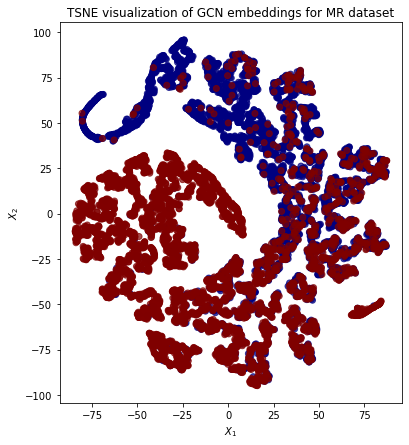

In [134]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=my_subs.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for MR dataset",
)